In [79]:
#importing the required modules

import numpy as np
import matplotlib.pyplot as plt
from prepareDF import PrepareDF, Labelencode
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from xgboost import XGBRegressor
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [84]:
MovieData = PrepareDF()
MovieData.head()

,title,director,cast,rating,genres
0,Ganglands,Julien Leclercq,"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, ...",7.2,"[Crime TV Shows, International TV Shows, TV ..."
1,Midnight Mass,Mike Flanagan,"[Kate Siegel, Zach Gilford, Hamish Linklater...",7.7,"[TV Dramas, TV Horror, TV Mysteries]"
2,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","[Vanessa Hudgens, Kimiko Glenn, James Marsde...",6.8,[Children & Family Movies]
3,Sankofa,Haile Gerima,"[Kofi Ghanaba, Oyafunmike Ogunlano, Alexandr...",7.0,"[Dramas, Independent Movies, International M..."
4,The Great British Baking Show,Andy Devonshire,"[Mel Giedroyc, Sue Perkins, Mary Berry, Pau...",8.6,"[British TV Shows, Reality TV]"


#### Preparing the data

In [85]:
MovieData = PrepareDF()

from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Combine the genres listed for each movie into a single string, separating them with '|' character
MovieData['genres'] = MovieData['genres'].apply(lambda x: '|'.join(x))

# Encoding 'director' column as integers
labelEncoder = LabelEncoder()
MovieData['director'] = labelEncoder.fit_transform(MovieData['director'])

# Selecting the 4 cast members with the most screen time
MovieData['cast'] = MovieData['cast'].apply(lambda x: x[:4] if len(x) >= 4 else x)

# Creating new columns for individual cast
for i in range(4):
    MovieData[f'cast_{i+1}'] = ''

for ind, item in enumerate(MovieData['cast']):
    MovieData['cast']
    for index, cast_a in enumerate(item[:4]):
        MovieData[f'cast_{index+1}'][ind] = cast_a

MovieData.drop(columns=['cast'], inplace=True)

# Encoding cast columns
MovieData['cast_1'] = labelEncoder.fit_transform(MovieData['cast_1'].values)
MovieData['cast_2'] = labelEncoder.fit_transform(MovieData['cast_2'].values)
MovieData['cast_3'] = labelEncoder.fit_transform(MovieData['cast_3'].values)
MovieData['cast_4'] = labelEncoder.fit_transform(MovieData['cast_4'].values)

# Apply one-hot encoding on genres
MovieData = pd.get_dummies(MovieData, columns=['genres'])

MovieData.head()

,title,director,rating,cast_1,cast_2,cast_3,cast_4,genres_Action & Adventure,genres_Action & Adventure| Anime Features,genres_Action & Adventure| Anime Features| Children & Family Movies,...,genres_Stand-Up Comedy & Talk Shows,genres_Stand-Up Comedy & Talk Shows| TV Comedies,genres_TV Action & Adventure| TV Sci-Fi & Fantasy,genres_TV Comedies,genres_TV Comedies| TV Dramas,genres_TV Dramas,genres_TV Dramas| TV Horror| TV Mysteries,genres_TV Horror| TV Mysteries| TV Thrillers,genres_TV Shows,genres_Thrillers
0,Ganglands,1787,7.2,2881,3435,3109,2559,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Midnight Mass,2437,7.7,1709,3621,1295,1391,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,My Little Pony: A New Generation,3025,6.8,3349,1910,1493,3387,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Sankofa,1276,7.0,1809,2635,135,2641,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,The Great British Baking Show,253,8.6,2191,3277,2304,2800,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Feature Engineering

In [86]:
# Calculate average ratings for director and cast
MovieData['director_avg_rating'] = MovieData.groupby('director')['rating'].transform('mean')

MovieData['cast_avg_rating'] = MovieData[['cast_1', 'cast_2', 'cast_3', 'cast_4']].mean(axis=1)

# Calculate average rating for each genre
genre_avg_ratings = {}
for genre in unique_genres:
    genre_avg_rating = MovieData[MovieData[genre] == 1]['rating'].mean()
    genre_avg_ratings[genre] = genre_avg_rating

# Assign average ratings to the DataFrame
for genre, avg_rating in genre_avg_ratings.items():
    MovieData.loc[MovieData[genre] == 1, 'genre_avg_rating'] = avg_rating


MovieData.head()

,title,director,rating,cast_1,cast_2,cast_3,cast_4,genres_Action & Adventure,genres_Action & Adventure| Anime Features,genres_Action & Adventure| Anime Features| Children & Family Movies,...,genres_TV Comedies,genres_TV Comedies| TV Dramas,genres_TV Dramas,genres_TV Dramas| TV Horror| TV Mysteries,genres_TV Horror| TV Mysteries| TV Thrillers,genres_TV Shows,genres_Thrillers,director_avg_rating,cast_avg_rating,genre_avg_rating
0,Ganglands,1787,7.2,2881,3435,3109,2559,False,False,False,...,False,False,False,False,False,False,False,5.733333,2996.00,6.266667
1,Midnight Mass,2437,7.7,1709,3621,1295,1391,False,False,False,...,False,False,False,True,False,False,False,6.750000,2004.00,7.700000
2,My Little Pony: A New Generation,3025,6.8,3349,1910,1493,3387,False,False,False,...,False,False,False,False,False,False,False,6.800000,2534.75,6.255346
3,Sankofa,1276,7.0,1809,2635,135,2641,False,False,False,...,False,False,False,False,False,False,False,7.000000,1805.00,6.643111
4,The Great British Baking Show,253,8.6,2191,3277,2304,2800,False,False,False,...,False,False,False,False,False,False,False,8.600000,2643.00,8.600000


In [87]:
# Create interaction features
MovieData['director_cast_interaction'] = MovieData['director_avg_rating'] * MovieData['cast_avg_rating']
MovieData['director_genre_interaction'] = MovieData['director_avg_rating'] * MovieData['genre_avg_rating']
MovieData['cast_genre_interaction'] = MovieData['cast_avg_rating'] * MovieData['genre_avg_rating']

MovieData.head()

,title,director,rating,cast_1,cast_2,cast_3,cast_4,genres_Action & Adventure,genres_Action & Adventure| Anime Features,genres_Action & Adventure| Anime Features| Children & Family Movies,...,genres_TV Dramas| TV Horror| TV Mysteries,genres_TV Horror| TV Mysteries| TV Thrillers,genres_TV Shows,genres_Thrillers,director_avg_rating,cast_avg_rating,genre_avg_rating,director_cast_interaction,director_genre_interaction,cast_genre_interaction
0,Ganglands,1787,7.2,2881,3435,3109,2559,False,False,False,...,False,False,False,False,5.733333,2996.00,6.266667,17177.066667,35.928889,18774.933333
1,Midnight Mass,2437,7.7,1709,3621,1295,1391,False,False,False,...,True,False,False,False,6.750000,2004.00,7.700000,13527.000000,51.975000,15430.800000
2,My Little Pony: A New Generation,3025,6.8,3349,1910,1493,3387,False,False,False,...,False,False,False,False,6.800000,2534.75,6.255346,17236.300000,42.536352,15855.738050
3,Sankofa,1276,7.0,1809,2635,135,2641,False,False,False,...,False,False,False,False,7.000000,1805.00,6.643111,12635.000000,46.501778,11990.815556
4,The Great British Baking Show,253,8.6,2191,3277,2304,2800,False,False,False,...,False,False,False,False,8.600000,2643.00,8.600000,22729.800000,73.960000,22729.800000


#### Preparing the training and testing datset for the simple ML models

In [88]:
# Split the data into training and test sets
X = MovieData[['director_avg_rating', 'cast_avg_rating', 'genre_avg_rating', 'director_genre_interaction', 'director_cast_interaction', 'cast_genre_interaction']]
Y = MovieData['rating']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Random Forest

In [95]:
#Initialize model
rf =RandomForestRegressor(n_estimators=100, max_depth=200)

#Fitting the model
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)

Calculating the errors and accuracy of the model

In [96]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, Y_pred)
print(f"Mean Absolute Error: {mae}") 

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r2 = r2_score(Y_test, Y_pred)
print(f"R-squared: {r2}")

#Explained Variance
explained_variance = np.var(Y_test - Y_pred) / np.var(Y_test)
print("EV : ", explained_variance)

Mean Absolute Error: 0.26441914342133216
Mean Squared Error: 0.24172855321148687
R-squared: 0.832308736468264
EV :  0.16624218835007998


Result Visualization

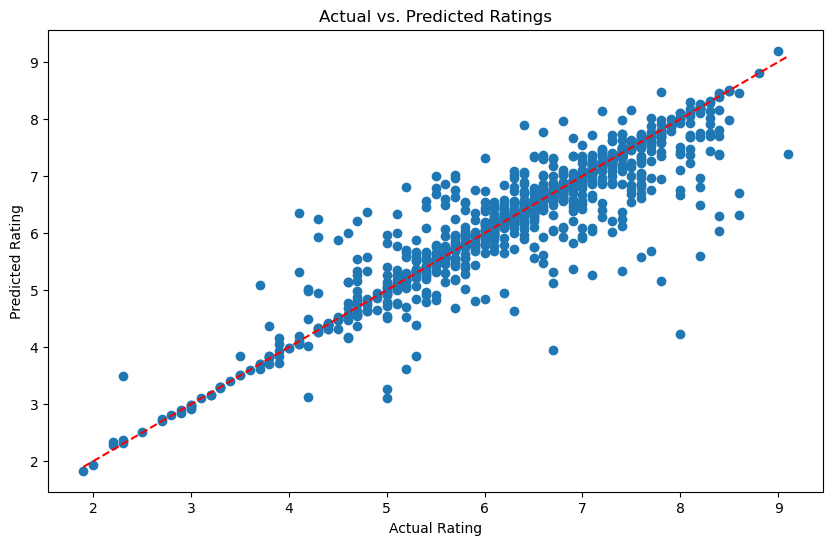

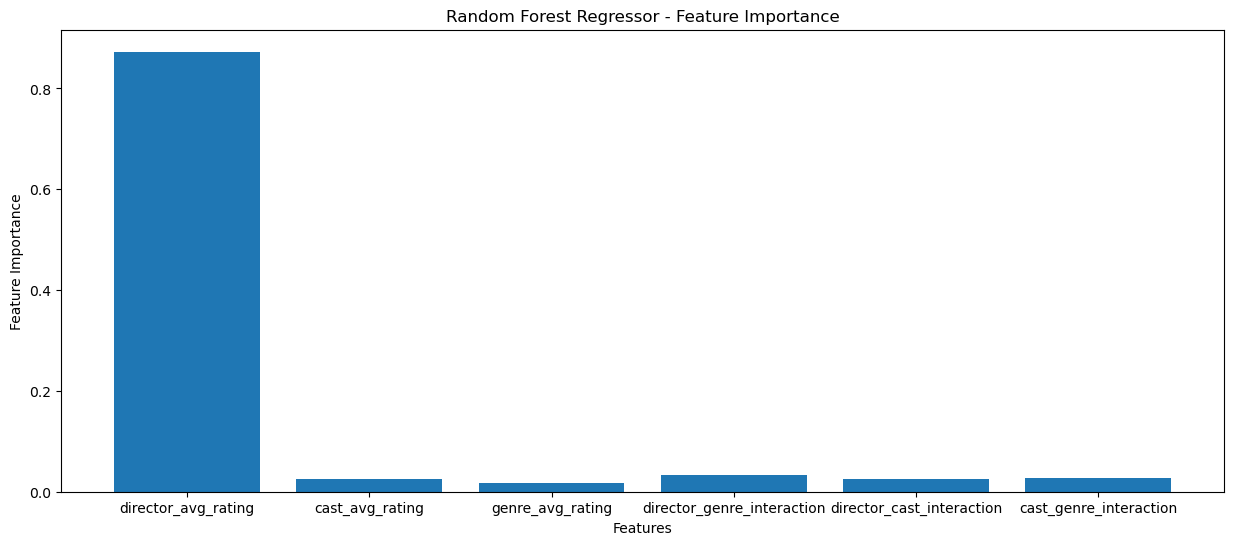

In [99]:
#scatter plot (actual vs predicted)
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', color='red')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs. Predicted Ratings')
plt.show()

# Coefficient plot
feature_importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(15, 6)) # Create a feature importance plot
plt.bar(feature_names, feature_importances)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Random Forest Regressor - Feature Importance')
plt.xticks(rotation=0)
plt.show()

## XGboost

In [91]:
# Initialize the model
xgboost=XGBRegressor(n_estimators=50)

# Fit the model
xgboost.fit(X_train,Y_train)
predictions=xgboost.predict(X_test)

Calculating the errors and accuracy of the model

In [93]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, Y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r2 = r2_score(Y_test, Y_pred)
print(f"R-squared: {r2}")

#Explained Variance
explained_variance = np.var(Y_test - Y_pred) / np.var(Y_test)
print("EV : ", explained_variance)

Mean Absolute Error: 0.26561573771138536
Mean Squared Error: 0.24266668161836008
R-squared: 0.831657940623861
EV :  0.16693281646403968


Result Visualization

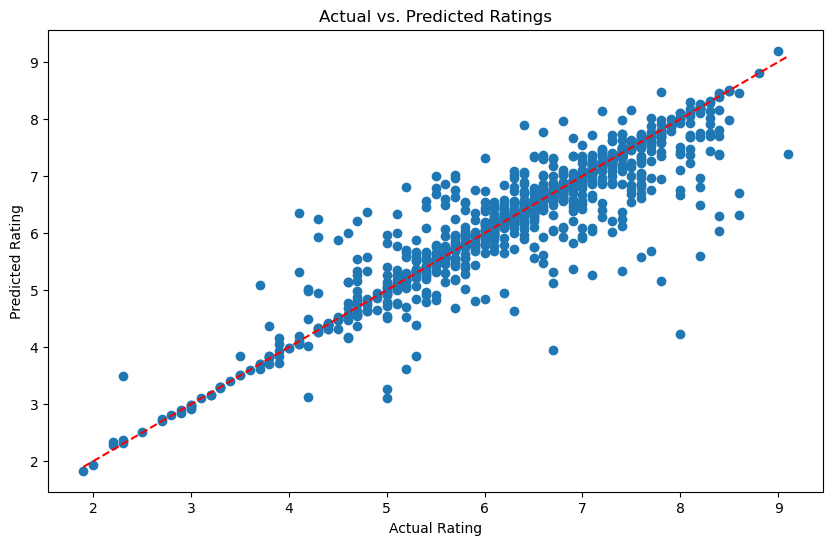

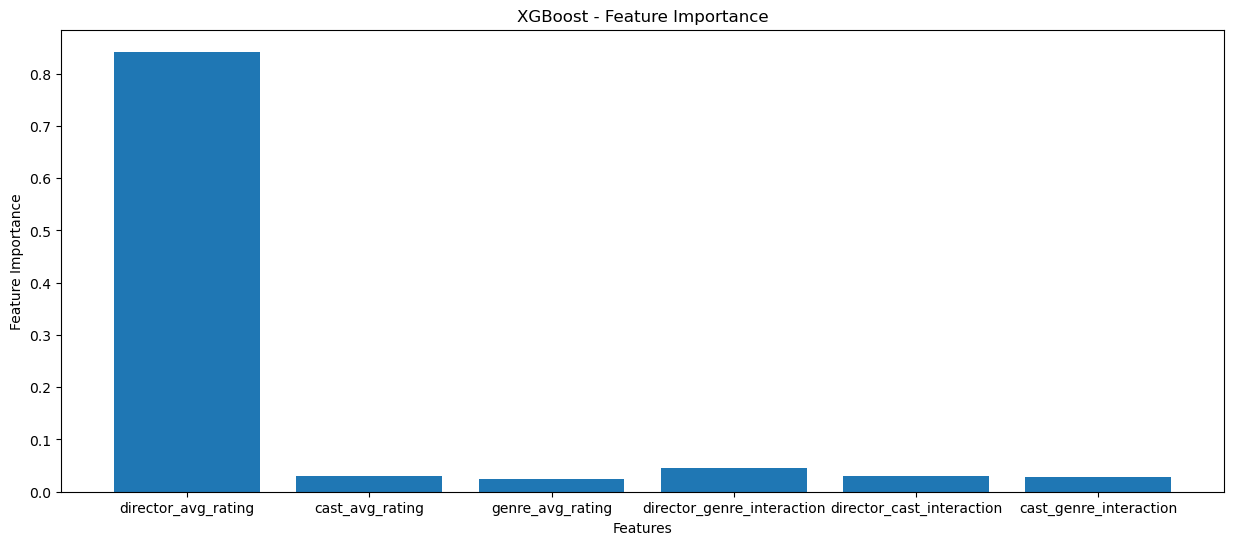

In [100]:
#scatter plot (actual vs predicted)
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', color='red')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs. Predicted Ratings')
plt.show()

# Coefficient plot
feature_importances = xgboost.feature_importances_
feature_names = X.columns

plt.figure(figsize=(15, 6)) # Create a feature importance plot
plt.bar(feature_names, feature_importances)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('XGBoost - Feature Importance')
plt.xticks(rotation=0)
plt.show()

Based on the feature importance graphs for both the models- genre does not have much importance when predicting the rating, hence we will discount in when constructing the neural network (but still take it's correlation with cast and director into account)